In [1]:
# Our dataset that we will use in the following code
!ls /kaggle/input/rec-system-data/
!ls /kaggle/input/rec-system-data/ml-1m/ml-1m/
!ls /kaggle/input/rec-system-data/name.basics.tsv
!ls /kaggle/input/rec-system-data/title.basics.tsv

ml-1m  name.basics.tsv	title.basics.tsv
README	movies.dat  ratings.dat  users.dat
/kaggle/input/rec-system-data/name.basics.tsv
/kaggle/input/rec-system-data/title.basics.tsv


# Imports

In [2]:
# All the different Imports
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

2024-07-07 13:31:54.408682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 13:31:54.408738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 13:31:54.410505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Looking at what each file contains

In [3]:
#Checking what is in name.basics.tsv
# Load and print the first few rows of the file
name_basics_path = '/kaggle/input/rec-system-data/name.basics.tsv'
name_basics_df = pd.read_csv(name_basics_path, sep='\t')
print(name_basics_df.head())

      nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                    primaryProfession                           knownForTitles  
0        actor,miscellaneous,producer  tt0072308,tt0050419,tt0053137,tt0027125  
1  actress,soundtrack,archive_footage  tt0037382,tt0075213,tt0117057,tt0038355  
2   actress,music_department,producer  tt0057345,tt0049189,tt0056404,tt0054452  
3       actor,writer,music_department  tt0072562,tt0077975,tt0080455,tt0078723  
4               writer,director,actor  tt0050986,tt0083922,tt0050976,tt0069467  


In [4]:
#Checking what is in title.basics.tsv
# Load and print the first few rows of the file
title_basics_path = '/kaggle/input/rec-system-data/title.basics.tsv'
title_basics_df  = pd.read_csv(title_basics_path, sep='\t')
print(title_basics_df.head())

/tmp/ipykernel_908/396690727.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics_df  = pd.read_csv(title_basics_path, sep='\t')


      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              5  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short  


In [5]:
#Checking what is in movies.dat
movies_path = '/kaggle/input/rec-system-data/ml-1m/ml-1m/movies.dat'
with open(movies_path, 'r', encoding='ISO-8859-1') as f:
    for _ in range(5):
        print(f.readline().strip())

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy


In [6]:
#Checking what is in ratings.dat
ratings_path = '/kaggle/input/rec-system-data/ml-1m/ml-1m/ratings.dat'
with open(ratings_path, 'r', encoding='ISO-8859-1') as f:
    for _ in range(5):
        print(f.readline().strip())

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968
1::3408::4::978300275
1::2355::5::978824291


In [7]:
#Checking what is in users.dat
users_path = '/kaggle/input/rec-system-data/ml-1m/ml-1m/users.dat'
with open(users_path, 'r', encoding='ISO-8859-1') as f:
    for _ in range(5):
        print(f.readline().strip())

1::F::1::10::48067
2::M::56::16::70072
3::M::25::15::55117
4::M::45::7::02460
5::M::25::20::55455


### Preprocessing Data

In [8]:
# We don't need all the columns so we will drop useless ones
movies_df = pd.read_csv(movies_path, sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
ratings_df = pd.read_csv(ratings_path, sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='ISO-8859-1')
users_df = pd.read_csv(users_path, sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python', encoding='ISO-8859-1')

# Drop the specified columns
ratings_df = ratings_df.drop(columns=['Timestamp'])
users_df = users_df.drop(columns=['Zip-code', 'Occupation'])
title_basics_df = title_basics_df.drop(columns=['primaryTitle', 'endYear', 'titleType'])
name_basics_df = name_basics_df.drop(columns=['primaryProfession', 'birthYear', 'deathYear'])

In [9]:
# Fixing movie title. Current format : title (year). We want two seperate column
movies_df['Year'] = movies_df['Title'].str[-5:-1]
movies_df['Title'] = movies_df['Title'].str[:-7]

# checking type
# Print the columns and their types
def print_columns_and_types(df, name):
    print(f"\n{name} columns and types:")
    print(df.dtypes)
    print(f"\nFirst few rows of {name}:")
    print(df.head())

print_columns_and_types(movies_df, "Movies DataFrame")
print_columns_and_types(ratings_df, "Ratings DataFrame")
print_columns_and_types(users_df, "Users DataFrame")
print_columns_and_types(name_basics_df, "Name Basics DataFrame")
print_columns_and_types(title_basics_df, "Title Basics DataFrame")



Movies DataFrame columns and types:
MovieID     int64
Title      object
Genres     object
Year       object
dtype: object

First few rows of Movies DataFrame:
   MovieID                        Title                        Genres  Year
0        1                    Toy Story   Animation|Children's|Comedy  1995
1        2                      Jumanji  Adventure|Children's|Fantasy  1995
2        3             Grumpier Old Men                Comedy|Romance  1995
3        4            Waiting to Exhale                  Comedy|Drama  1995
4        5  Father of the Bride Part II                        Comedy  1995

Ratings DataFrame columns and types:
UserID     int64
MovieID    int64
Rating     int64
dtype: object

First few rows of Ratings DataFrame:
   UserID  MovieID  Rating
0       1     1193       5
1       1      661       3
2       1      914       3
3       1     3408       4
4       1     2355       5

Users DataFrame columns and types:
UserID     int64
Gender    object
Age        

In [10]:
# We see that year, startyear and isAdult are not the correct type
if 'year' in movies_df.columns:
    movies_df['year'] = pd.to_numeric(movies_df['year'], errors='coerce')

if 'startYear' in title_basics_df.columns:
    title_basics_df['startYear'] = pd.to_numeric(title_basics_df['startYear'], errors='coerce')

if 'isAdult' in title_basics_df.columns:
    title_basics_df['isAdult'] = pd.to_numeric(title_basics_df['isAdult'], errors='coerce')


In [11]:
# We lowercase and remove trailing spaces so they match better
movies_df['Title'] = movies_df['Title'].str.lower().str.strip()
title_basics_df['originalTitle'] = title_basics_df['originalTitle'].str.lower().str.strip()

In [12]:
# We merge the dataframes together
movies2_df = pd.merge(movies_df, ratings_df, on='MovieID', how='left')


In [13]:
movies3_df = pd.merge(movies2_df, users_df, on='UserID', how='left')

In [14]:
# Rename columns for clarity before merging
title_basics_df = title_basics_df.rename(columns={'originalTitle': 'Title'})
full_df = pd.merge(movies3_df, title_basics_df, on='Title', how='left')

In [15]:
# Merge genres columns. I takes a LONG WHILE
def merge_genres(row):
    genres = set()
    if pd.notna(row['Genres']):
        genres.update(row['Genres'].split('|'))
    if pd.notna(row['genres']):
        genres.update(row['genres'].replace(',', '|').split('|'))
    return '|'.join(genres)

full_df['MergedGenres'] = full_df.apply(merge_genres, axis=1)
full_df = full_df.drop(columns=['Genres', 'genres'])


In [16]:
full_df = full_df.drop(columns=['tconst'])

In [17]:
# Delete the uneeded df
del title_basics_df
del name_basics_df
del movies_df
del movies2_df
del movies3_df
del users_df
del ratings_df


In [18]:
# Full df
print_columns_and_types(full_df, "Title Basics DataFrame")


Title Basics DataFrame columns and types:
MovieID             int64
Title              object
Year               object
UserID            float64
Rating            float64
Gender             object
Age               float64
isAdult           float64
startYear         float64
runtimeMinutes     object
MergedGenres       object
dtype: object

First few rows of Title Basics DataFrame:
   MovieID      Title  Year  UserID  Rating Gender  Age  isAdult  startYear  \
0        1  toy story  1995     1.0     5.0      F  1.0      0.0     1995.0   
1        1  toy story  1995     1.0     5.0      F  1.0      0.0     1995.0   
2        1  toy story  1995     1.0     5.0      F  1.0      0.0     1999.0   
3        1  toy story  1995     1.0     5.0      F  1.0      0.0     1997.0   
4        1  toy story  1995     1.0     5.0      F  1.0      0.0     1997.0   

  runtimeMinutes                                       MergedGenres  
0             81              Adventure|Children's|Animation|Comedy  

In [19]:
# This method only needs the user ratings, the userID and the MovieID
data = {
    'MovieID': full_df['MovieID'],
    'Rating': full_df['Rating'],
    'UserID': full_df['UserID'],
}

copy_df = pd.DataFrame(data)
del data

In [20]:
# Drop rows with any NaN values
copy_df.dropna(inplace=True)

In [21]:
# Convert fields to integer to make sure they are the correct type
copy_df['MovieID'] = copy_df['MovieID'].astype(int)
copy_df['Rating'] = copy_df['Rating'].astype(np.float32)
copy_df['UserID'] = copy_df['UserID'].astype(int)

In [22]:
print_columns_and_types(copy_df, "Title Basics DataFrame")


Title Basics DataFrame columns and types:
MovieID      int64
Rating     float32
UserID       int64
dtype: object

First few rows of Title Basics DataFrame:
   MovieID  Rating  UserID
0        1     5.0       1
1        1     5.0       1
2        1     5.0       1
3        1     5.0       1
4        1     5.0       1


In [23]:
# This part is responsible for converting the original user and movie IDs into a format that can be easily used by the neural network

# Map user ID to a "user vector" via an embedding matrix
user_ids = copy_df["UserID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = copy_df["MovieID"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

copy_df["UserID"] = copy_df["UserID"].map(user2user_encoded)
copy_df["MovieID"] = copy_df["MovieID"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)




In [24]:
# This part of the code is responsible for preparing the data for training and validation. 

copy_df = copy_df.sample(frac=1, random_state=42)
x = copy_df[["UserID", "MovieID"]].values

# Normalizing the targets between 0 and 1. Makes it easy to train.
y = copy_df["Rating"].apply(lambda x: (x - 1) / (5 - 1)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * copy_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

### TESTING FIRST MODEL TAKEN FROM ONLINE

In [25]:
# This part of the code is responsible for preparing the data for training and validation. 

copy_df = copy_df.sample(frac=1, random_state=42)
x = copy_df[["UserID", "MovieID"]].values

# Normalizing the targets between 0 and 1. Makes it easy to train.
y = copy_df["Rating"].apply(lambda x: (x - 1) / (5 - 1)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * copy_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [26]:
# This part of the code creates the neural network model for the recommender system 

# I chose this model because it can understand what movies someone might like based on what they've watched before. 
# It uses a technique called embeddings to represent users and movies in a simpler way, so it can learn patterns to predict better
# By predicting if a user will like a movie (using numbers between 0 and 1), it helps suggest movies they might enjoy more accurately.
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)
    
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [47]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=2,
    validation_data=(x_val, y_val)
)

Epoch 1/2
219005/219005 ━━━━━━━━━━━━━━━━━━━━ 422s 2ms/step - accuracy: 0.2263 - loss: 0.0739 - val_accuracy: 0.2266 - val_loss: 0.0740
Epoch 2/2
219005/219005 ━━━━━━━━━━━━━━━━━━━━ 420s 2ms/step - accuracy: 0.2263 - loss: 0.0738 - val_accuracy: 0.2266 - val_loss: 0.0740


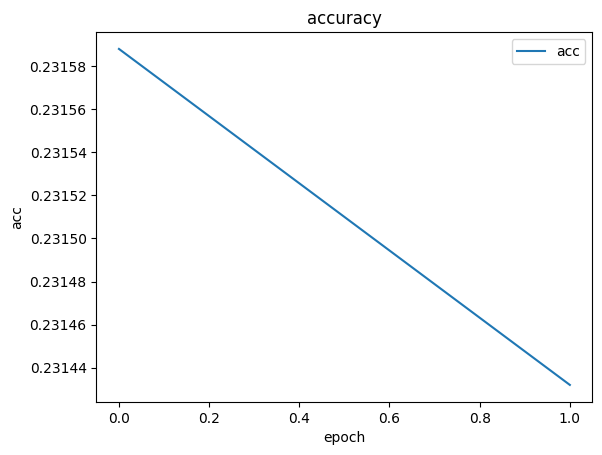

In [28]:
# Graph to show accuracy between epochs
plt.plot(history.history['val_binary_accuracy'], label='acc')
plt.title('accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()

In [29]:
# Function to get title and genre from multiple movieID's
def print_movie_titles_and_genres(movie_ids, full_df):
    for movie_id in movie_ids:
        movie_details = get_movie_title_and_genres(movie_id, full_df)
        print(f"MovieID: {movie_id}, {movie_details}")

In [30]:
# Function to get title and genre from 1 movieID
def get_movie_title_and_genres(movie_id, full_df):
    # Filter the DataFrame for the given MovieID
    movie_row = full_df[full_df['MovieID'] == movie_id].drop_duplicates(subset=['MovieID'])
    if not movie_row.empty:
        title = movie_row['Title'].values[0]
        genres = movie_row['MergedGenres'].values[0]
        return f"{title} ({genres})"
    else:
        return "Unknown Movie"

In [31]:
def recommend_movies_for_two_users(user_id_1, user_id_2, copy_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie, model):
    # Combine movies watched by both users
    movies_watched_by_user_1 = copy_df[copy_df['UserID'] == user_id_1]
    movies_watched_by_user_2 = copy_df[copy_df['UserID'] == user_id_2]
    movies_watched_by_both = pd.concat([movies_watched_by_user_1, movies_watched_by_user_2])

    # Find movies neither of them has watched
    movies_not_watched = copy_df[~copy_df['MovieID'].isin(movies_watched_by_both['MovieID'].values)]['MovieID']
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched_encoded = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    # Encode the users
    user_encoder_1 = user2user_encoded.get(user_id_1)
    user_encoder_2 = user2user_encoded.get(user_id_2)

    # Create user-movie array for both users
    user_movie_array_1 = np.hstack(([[user_encoder_1]] * len(movies_not_watched_encoded), movies_not_watched_encoded))
    user_movie_array_2 = np.hstack(([[user_encoder_2]] * len(movies_not_watched_encoded), movies_not_watched_encoded))

    # Predict ratings for both users
    ratings_1 = model.predict(user_movie_array_1).flatten()
    ratings_2 = model.predict(user_movie_array_2).flatten()

    # Average the ratings
    average_ratings = (ratings_1 + ratings_2) / 2

    # Get top 10 movie recommendations based on the highest average ratings
    top_ratings_indices = average_ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched_encoded[x][0]) for x in top_ratings_indices]

    # Display recommendations
    top_recommendation = get_movie_title_and_genres(recommended_movie_ids[0], full_df)
    print(f"The recommended movie for user {user_id_1} and user {user_id_2} is {top_recommendation}")
    return recommended_movie_ids

In [50]:
user_ID_1 = 2
user_ID_2 = 1
recommended_movie_ids = recommend_movies_for_two_users(user_ID_1,user_ID_2, copy_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie, model)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
The recommended movie for user 2 and user 1 is waiting to exhale (Drama|Romance|Comedy)


In [51]:
# For more details
print("Movies with high ratings from either user")
print("----" * 8)
top_movies_user_1 = copy_df[copy_df['UserID'] == user_ID_1].sort_values(by="Rating", ascending=False).head(5)['MovieID'].values
top_movies_user_2 = copy_df[copy_df['UserID'] == user_ID_2].sort_values(by="Rating", ascending=False).head(5)['MovieID'].values
print("User 1's top movies:")
print_movie_titles_and_genres(top_movies_user_1, full_df)
print("User 2's top movies:")
print_movie_titles_and_genres(top_movies_user_2, full_df)
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
print_movie_titles_and_genres(recommended_movie_ids, full_df)

#The recommendation seem to be logical, at least GENRE wise when tested for 10-15 different user combination

Movies with high ratings from either user
--------------------------------
User 1's top movies:
MovieID: 1309, parallel sons (Drama|Romance)
MovieID: 3032, omega man, the (Sci-Fi)
MovieID: 157, canadian bacon (War|Action|Comedy)
MovieID: 451, flesh and bone (Drama|Mystery|Romance)
MovieID: 1309, parallel sons (Drama|Romance)
User 2's top movies:
MovieID: 853, dingo (Drama|Music)
MovieID: 1551, buddy (Drama|Adventure|Children's|Comedy)
MovieID: 1281, great dictator, the (Comedy)
MovieID: 1281, great dictator, the (Comedy)
MovieID: 1551, buddy (Drama|Adventure|Children's|Comedy)
--------------------------------
Top 10 movie recommendations
--------------------------------
MovieID: 4, waiting to exhale (Drama|Romance|Comedy)
MovieID: 5, father of the bride part ii (Family|Romance|Comedy)
MovieID: 1269, arsenic and old lace (Crime|Thriller|Mystery|Comedy)
MovieID: 1268, pump up the volume (Drama|Music|Comedy)
MovieID: 1267, manchurian candidate, the (Film-Noir|Thriller)
MovieID: 1266, unfo

### TESTING CUSTOM MODEL

In [34]:
# I wanted to try a more traditional neural network approach and see if it works well.
# It probably wont but I wanted to see the results


from tensorflow.keras import models, layers, optimizers

def build_recommendation_model(num_features):
    model = models.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')  
    ])
    
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[ 'accuracy'])
    return model


In [52]:
model = build_recommendation_model(x_train.shape[1])
model.fit(x_train, y_train, epochs=2, batch_size=32, validation_split=0.1)


Epoch 1/2
394209/394209 ━━━━━━━━━━━━━━━━━━━━ 752s 2ms/step - accuracy: 0.2190 - loss: 1.9073 - val_accuracy: 0.2266 - val_loss: 0.0736
Epoch 2/2
394209/394209 ━━━━━━━━━━━━━━━━━━━━ 750s 2ms/step - accuracy: 0.2264 - loss: 0.0733 - val_accuracy: 0.2266 - val_loss: 0.0738


In [53]:

recommended_movie_ids = recommend_movies_for_two_users(user_ID_1,user_ID_2, copy_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie, model)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
The recommended movie for user 2 and user 1 is toy story (Adventure|Children's|Animation|Comedy)


In [54]:
# For more details
print("Movies with high ratings from either user")
print("----" * 8)
top_movies_user_1 = copy_df[copy_df['UserID'] == user_ID_1].sort_values(by="Rating", ascending=False).head(5)['MovieID'].values
top_movies_user_2 = copy_df[copy_df['UserID'] == user_ID_2].sort_values(by="Rating", ascending=False).head(5)['MovieID'].values
print("User 1's top movies:")
print_movie_titles_and_genres(top_movies_user_1, full_df)
print("User 2's top movies:")
print_movie_titles_and_genres(top_movies_user_2, full_df)
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
print_movie_titles_and_genres(recommended_movie_ids, full_df)

#The recommendation seem to be ok but not that great when tested for 10-15 different user combination

Movies with high ratings from either user
--------------------------------
User 1's top movies:
MovieID: 1309, parallel sons (Drama|Romance)
MovieID: 3032, omega man, the (Sci-Fi)
MovieID: 157, canadian bacon (War|Action|Comedy)
MovieID: 451, flesh and bone (Drama|Mystery|Romance)
MovieID: 1309, parallel sons (Drama|Romance)
User 2's top movies:
MovieID: 853, dingo (Drama|Music)
MovieID: 1551, buddy (Drama|Adventure|Children's|Comedy)
MovieID: 1281, great dictator, the (Comedy)
MovieID: 1281, great dictator, the (Comedy)
MovieID: 1551, buddy (Drama|Adventure|Children's|Comedy)
--------------------------------
Top 10 movie recommendations
--------------------------------
MovieID: 1, toy story (Adventure|Children's|Animation|Comedy)
MovieID: 3705, bird on a wire (Adventure|Comedy|Thriller|Action|Romance|Crime)
MovieID: 3704, mad max beyond thunderdome (Adventure|Sci-Fi|Action)
MovieID: 3703, mad max 2 (a.k.a. the road warrior) (Sci-Fi|Action)
MovieID: 3702, mad max (Adventure|Sci-Fi|Acti

### RESULTS

The first recommendation system tried works well. The More traditional neural network less so. They both have an accuracy near 0.23 but only one gives coherent results when we try it.

# For more details read the README